# Finding Eigenvalues of Real, Symetric Matrices with Neural Networks

We wish to find the eigenvalues of a real, symmetric matrix A by solving the differential equation

$$
    \frac{d \pmb x(t)}{d t} = - \pmb x(t) + f(\pmb x(t))
$$

where 

$$
    f(\pmb  x) = [\pmb x^T \pmb x A + (1 - \pmb x^T A \pmb x)I] \pmb x
$$

Using a feed forward Neural network.

In this notebook, we train the Neural network on 30 data points in a time domain of $t \in [0, 3]$. We also have another similar notebook that has been trained on 300 data points in the same domain, also using the same seed meaning that they both aim to find the eigenpairs of the same matrix $A$

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian

sys.path.insert(0, "../src")
from utils import minibatch, heat_eq_analytic

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
})

dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

In [2]:
def costfunction(t, N, A, trial_func):
    """
    Costfunction used to train the Neural Network.
    
    t (Tensor) : Time; input to the neural network.
    N (Tensor) : Output of the Neural network
    A (Tensor) : The 6x6 real, symmetric matrix we're finding solving for
    trial_func (Function) : the trial function used to solve the DE
    """
    loss = 0
    
    for i in range(t.size(0)):
        # Compute trial eigenvector & transpose
        N_curr = N[i].reshape(-1,1)
        v = trial_func(t[i], N_curr)
        v_T = v.transpose(0,1)
       
        # Time derivative of trial function
        dfdt, dfdN = jacobian(trial_func, (t[i], N_curr), create_graph=True)  
        
        # right hand side of ODE
        RHS = (- v + (v_T.mm(v) * A  + (1 - v_T.mm(A).mm(v)) * torch.eye(v.size(0))).mm(v))
            
        # Increment the loss function
        loss = loss + (dfdt[:, 0] - RHS).pow(2).mean()
    
    return loss / t.size(0)

In [3]:
# Set a seed for reproducability. 
torch.manual_seed(2020)

# Make a random symetric + real matrix
Q = torch.randn(6,6, device=device, dtype=dtype, requires_grad=False)
A = torch.transpose(Q, 0, 1) + Q

A

tensor([[-0.0173,  0.7011, -2.4403,  0.6338,  0.3444, -2.7550],
        [ 0.7011, -3.4166,  1.1724, -0.2233, -1.4215, -0.9924],
        [-2.4403,  1.1724, -1.7178, -0.4207, -1.0524, -0.3791],
        [ 0.6338, -0.2233, -0.4207,  1.7434,  2.0975, -0.7133],
        [ 0.3444, -1.4215, -1.0524,  2.0975, -3.5050,  0.5459],
        [-2.7550, -0.9924, -0.3791, -0.7133,  0.5459, -1.8151]])

In [4]:
# Fetch the eigenpairs from numpy
eigval, eigvec = np.linalg.eigh(A.detach().numpy())

with np.printoptions(precision=2):
    print("",eigval)
    print()
    print(eigvec)

 [-5.42 -4.78 -3.9  -0.12  1.77  3.72]

[[-0.38  0.45 -0.1   0.12 -0.54  0.58]
 [ 0.56  0.18 -0.64 -0.42 -0.24 -0.02]
 [-0.31  0.51  0.28 -0.66  0.09 -0.34]
 [-0.17 -0.14 -0.21 -0.35  0.63  0.63]
 [ 0.58  0.56  0.38  0.25  0.3   0.24]
 [-0.29  0.41 -0.55  0.43  0.39 -0.32]]


In [5]:
# Number of points to train on
num_points = 30

# Time domain to train the network on
t = torch.linspace(0, 3, num_points, device=device, dtype=dtype, requires_grad=True).reshape(-1,1)

# Random initial guess for the eigenvector
v0 = torch.randn(A.size(0), device=device, dtype=dtype, requires_grad=False).reshape(-1,1)
v0 = v0 / torch.norm(v0)

# Trial solution to ODE
# Note: Passing v0 in a somewhat sloppy manner to avoid having to pass it every time i call f_trial.
def f_trial(t, N):
    return v0 * torch.exp(-t) + (1 - torch.exp(-t)) * N

In [6]:
# Shape of network
input_dim = 1
hidden_neurons = 50
output_dim = v0.size(0)

learning_rate = 2e-2
N_minibatches = int(num_points / 6)
print(N_minibatches)

model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, output_dim),
        )

# Use the ADAM optimization algorithm with standard parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Keep track of the total number of epochs the network has been trained for as well as a
# cumulative record of the loss wrt to each epoch.
TOT_EPOCHS_10 = 0

loss_arr_tot_10 = np.empty(0, dtype=np.float)
epoch_arr_tot_10 = np.empty(0, dtype=np.float)

5


Now that the model has been set up, the network may be trained by running the cell below. If unhappy with the current results, you may simply rerun the cell adjusting the EPOCHS variable if so desired. Further, the loss wrt the epochs is kept track of by appending the loss of the current run (loss_arr_curr_10) to the (loss_arr_tot_10) array that we defined previously, thus the complete history of the loss is kept throughout.

Note that the loss function is evaluated on the entire dataset inbetween each epoch, but the actual training is performed using minibatches!

0: loss =  tensor(0.3653, grad_fn=<DivBackward0>)
10: loss =  tensor(0.0087, grad_fn=<DivBackward0>)
20: loss =  tensor(0.0032, grad_fn=<DivBackward0>)
30: loss =  tensor(0.0015, grad_fn=<DivBackward0>)
40: loss =  tensor(0.0015, grad_fn=<DivBackward0>)
50: loss =  tensor(0.0009, grad_fn=<DivBackward0>)
60: loss =  tensor(0.0003, grad_fn=<DivBackward0>)
70: loss =  tensor(0.0002, grad_fn=<DivBackward0>)
80: loss =  tensor(0.0001, grad_fn=<DivBackward0>)
90: loss =  tensor(6.0715e-05, grad_fn=<DivBackward0>)
100: loss =  tensor(0.0001, grad_fn=<DivBackward0>)
110: loss =  tensor(0.0019, grad_fn=<DivBackward0>)
120: loss =  tensor(0.0048, grad_fn=<DivBackward0>)
130: loss =  tensor(0.0018, grad_fn=<DivBackward0>)
140: loss =  tensor(0.0003, grad_fn=<DivBackward0>)
150: loss =  tensor(0.0002, grad_fn=<DivBackward0>)
160: loss =  tensor(0.0001, grad_fn=<DivBackward0>)
170: loss =  tensor(5.2385e-05, grad_fn=<DivBackward0>)
180: loss =  tensor(7.1313e-05, grad_fn=<DivBackward0>)
190: loss =

Text(0.5, 0, 'Epoch')

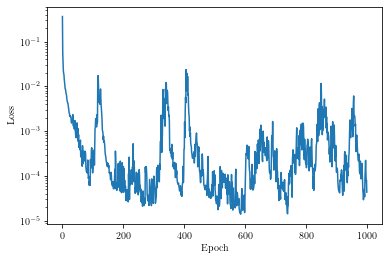

In [7]:
EPOCHS = 1000

loss_arr_curr_10 = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_10 = np.empty(EPOCHS, dtype=np.float)

for epoch in range(EPOCHS):
    mb = minibatch(num_points, N_minibatches)
    
    for i in range(N_minibatches):
        # Compute the output of the model
        N_output = model(t[mb[i]])
        
        # Compute and print loss
        loss = costfunction(t[mb[i]], N_output, A, f_trial)
        
        # Use autograd to compute the backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute loss over the entire sample to track the training progress
    N_output = model(t) 
    loss = costfunction(t, N_output, A, f_trial)
    
    if epoch % 10 == 0:
        print(f"{TOT_EPOCHS_10 + epoch}: loss = ",loss) 
    
    loss_arr_curr_10[epoch] = loss
    epoch_arr_curr_10[epoch] = TOT_EPOCHS_10 + epoch  
        
        
TOT_EPOCHS_10 += EPOCHS    
loss_arr_tot_10 = np.append(loss_arr_tot_10, loss_arr_curr_10)
epoch_arr_tot_10 = np.append(epoch_arr_tot_10, epoch_arr_curr_10)

plt.semilogy(epoch_arr_tot_10, loss_arr_tot_10)
plt.ylabel("Loss")
plt.xlabel("Epoch")

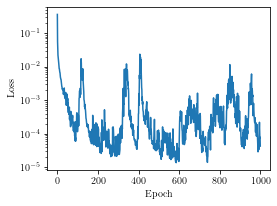

In [8]:
plt.figure(figsize=(4,3))
plt.semilogy(epoch_arr_tot_10, loss_arr_tot_10)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("../figs/eigenval_loss.pdf")

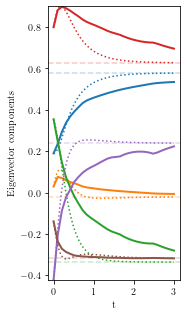

In [34]:
# Fetch the outcome of the model and use it to compute the solution with the trial function.
N_output = model(t) 
v_pred_np = np.zeros([t.size(0), 6])

for i in range(t.size(0)):
    ft = f_trial(t[i,:], N_output[i,:].reshape(-1,1)).detach().numpy().reshape(6)
    v_pred_np[i] = ft / np.sqrt(np.dot(ft, ft)) # Normalize the eigenvectors

# Solve ODE analytically using FW Euler
x_t = v0.detach().numpy()
A_t = A.detach().numpy()
dt = 0.01
N = 300
time = np.linspace(0, dt * N, N)
x_euler = np.zeros([N, 6])

for i in range(N):
    x_euler[i, :] = x_t.reshape(6)
    x_euler[i, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    x_t = x_t + (-x_t + (x_t.T @ x_t * A_t + (1 - x_t.T @ A_t @ x_t) * np.identity(6)) @ x_t)*dt

x_euler[N-1, :] = x_t.reshape(6)
x_euler[N-1, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))

# Plot the results
plt.figure(figsize=(3*0.9, 5*0.9))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

for d in range(6):
    plt.plot(t.detach().numpy(), v_pred_np[:, d], ls = "solid", color=colors[d], linewidth=2)
    plt.plot(time, x_euler[:, d], ls=":" , color=colors[d], linewidth=1.5)
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")

y_min = min([np.amin(x_euler), np.amin(v_pred_np)])
y_max = max([np.amax(x_euler), np.amax(v_pred_np)])
plt.ylim(y_min,y_max)

plt.xlabel("t")
plt.ylabel("Eigenvector components")

plt.tight_layout()
plt.savefig("../figs/eigenvec_dynamics.pdf")
plt.show()

In [31]:
# Compute eigenvalue
eigval_nn = (v_pred_np[-1, :].T @ A_t @ v_pred_np[-1, :] / (v_pred_np[-1, :].T @ v_pred_np[-1, :]))

print("NN Eigenvalue: %10.3f" % eigval_nn)
print("Numpy Eigenvalue: %7.3f" % eigval[-1])

with np.printoptions(precision=3):
    print("\nEigenvectors:")
    print(v_pred_np[-1, :], "NN")
    print(eigvec[:,-1], "Numpy")

# Note; eigvec is normed!
print("\ndot product: %.3f" % np.dot(eigvec[:, -1], v_pred_np[-1, :]))

NN Eigenvalue:      3.689
Numpy Eigenvalue:   3.722

Eigenvectors:
[ 0.535 -0.007 -0.281  0.696  0.223 -0.318] NN
[ 0.578 -0.021 -0.337  0.627  0.239 -0.318] Numpy

dot product: 0.995


# Compute the smallest eigenvalue & the corresponding eigenvector

We not repeat the same process, but instead training the network on $-A$, thus finding the smallest eigenvalue of $A$, and its corresponding eigenvector.

In [11]:
A_neg = - torch.clone(A)
A_neg

tensor([[ 0.0173, -0.7011,  2.4403, -0.6338, -0.3444,  2.7550],
        [-0.7011,  3.4166, -1.1724,  0.2233,  1.4215,  0.9924],
        [ 2.4403, -1.1724,  1.7178,  0.4207,  1.0524,  0.3791],
        [-0.6338,  0.2233,  0.4207, -1.7434, -2.0975,  0.7133],
        [-0.3444,  1.4215,  1.0524, -2.0975,  3.5050, -0.5459],
        [ 2.7550,  0.9924,  0.3791,  0.7133, -0.5459,  1.8151]])

In [12]:
# Shape of network
input_dim = 1
hidden_neurons = 50
output_dim = v0.size(0)

learning_rate = 2e-2
N_minibatches = int(num_points/5) # -> Regular SGD
print(N_minibatches)

model_small = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, output_dim),
        )
optimizer_small = torch.optim.Adam(model_small.parameters(), lr=learning_rate)


TOT_EPOCHS_small = 0

loss_arr_tot_small = np.empty(0, dtype=np.float)
epoch_arr_tot_small = np.empty(0, dtype=np.float)

6


0: loss =  tensor(0.2153, grad_fn=<DivBackward0>)
10: loss =  tensor(0.0150, grad_fn=<DivBackward0>)
20: loss =  tensor(0.0086, grad_fn=<DivBackward0>)
30: loss =  tensor(0.0063, grad_fn=<DivBackward0>)
40: loss =  tensor(0.0045, grad_fn=<DivBackward0>)
50: loss =  tensor(0.0036, grad_fn=<DivBackward0>)
60: loss =  tensor(0.0028, grad_fn=<DivBackward0>)
70: loss =  tensor(0.0020, grad_fn=<DivBackward0>)
80: loss =  tensor(0.0021, grad_fn=<DivBackward0>)
90: loss =  tensor(0.0016, grad_fn=<DivBackward0>)
100: loss =  tensor(0.0012, grad_fn=<DivBackward0>)
110: loss =  tensor(0.0004, grad_fn=<DivBackward0>)
120: loss =  tensor(0.0005, grad_fn=<DivBackward0>)
130: loss =  tensor(0.0004, grad_fn=<DivBackward0>)
140: loss =  tensor(0.0005, grad_fn=<DivBackward0>)
150: loss =  tensor(0.0002, grad_fn=<DivBackward0>)
160: loss =  tensor(0.0002, grad_fn=<DivBackward0>)
170: loss =  tensor(0.0001, grad_fn=<DivBackward0>)
180: loss =  tensor(0.0001, grad_fn=<DivBackward0>)
190: loss =  tensor(0.0

Text(0.5, 0, 'Epoch')

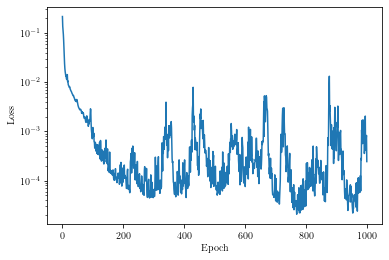

In [13]:
EPOCHS = 1000

loss_arr_curr_small = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_small = np.empty(EPOCHS, dtype=np.float)

for epoch in range(EPOCHS):
    mb = minibatch(num_points, N_minibatches)
    
    for i in range(N_minibatches):
        # Compute the output of the model
        N_output = model_small(t[mb[i]])
        
        # Compute and print loss
        loss = costfunction(t[mb[i]], N_output, A_neg, f_trial)
        
        # Use autograd to compute the backward pass.
        optimizer_small.zero_grad()
        loss.backward()
        optimizer_small.step()
    
    # Compute loss over the entire sample to track the training progress
    N_output = model_small(t) 
    loss = costfunction(t, N_output, A_neg, f_trial)

    if epoch % 10 == 0:
        print(f"{TOT_EPOCHS_small + epoch}: loss = ",loss) 
    
    loss_arr_curr_small[epoch] = loss
    epoch_arr_curr_small[epoch] = TOT_EPOCHS_small + epoch  
        
        
TOT_EPOCHS_small += EPOCHS    
loss_arr_tot_small = np.append(loss_arr_tot_small, loss_arr_curr_small)
epoch_arr_tot_small = np.append(epoch_arr_tot_small, epoch_arr_curr_small)

plt.semilogy(epoch_arr_tot_small, loss_arr_tot_small)
plt.ylabel("Loss")
plt.xlabel("Epoch")

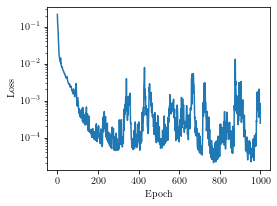

In [14]:
plt.figure(figsize=(4,3))
plt.semilogy(epoch_arr_tot_small, loss_arr_tot_small)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("../figs/eigenval_small_loss.pdf")

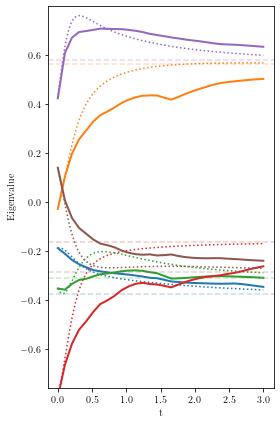

In [33]:
# Fetch the outcome of the model and use it to compute the solution with the trial function.
N_output = model_small(t) 
v_pred_np_small = np.zeros([t.size(0), 6])

for i in range(t.size(0)):
    ft = f_trial(t[i,:], N_output[i,:].reshape(-1,1)).detach().numpy().reshape(6)
    v_pred_np_small[i] = ft / np.sqrt(np.dot(ft, ft)) # Normalize the eigenvectors

# Solve ODE analytically using FW Euler
x_t = v0.detach().numpy()
A_t = A_neg.detach().numpy()
dt = 0.01
N = 300
time = np.linspace(0, dt * N, N)
x_euler = np.zeros([N, 6])

for i in range(N):
    x_euler[i, :] = x_t.reshape(6)
    x_euler[i, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    x_t = x_t + (-x_t + (x_t.T @ x_t * A_t + (1 - x_t.T @ A_t @ x_t) * np.identity(6)) @ x_t)*dt

x_euler[N-1, :] = x_t.reshape(6)
x_euler[N-1, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))

# Plot the results
plt.figure(figsize=(4, 6))
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

for d in range(6):
    plt.plot(t.detach().numpy(), -v_pred_np_small[:, d], ls = "solid", color=colors[d], linewidth=2)
    plt.plot(time, -x_euler[:, d], ls=":" , color=colors[d], linewidth=1.5)
    plt.axhline(eigvec[d, 0], alpha=0.25, color=colors[d], ls="--")

y_min = min([np.amin(x_euler), np.amin(v_pred_np_small)])
y_max = max([np.amax(x_euler), np.amax(v_pred_np_small)])
plt.ylim(y_min,y_max)

plt.xlabel("t")
plt.ylabel("Eigenvalue")

plt.tight_layout()
#plt.savefig("test.png")
plt.show()

In [37]:
# Compute eigenvalue
eigval_nn_small = ((-v_pred_np_small[-1, :]).T @ A_t @ (-v_pred_np_small[-1, :])
                   / ((-v_pred_np_small[-1, :]).T @ (-v_pred_np_small[-1, :])))

print("NN Eigenvalue: %10.3f" % eigval_nn_small)
print("Numpy Eigenvalue: %7.3f" % eigval[0])

with np.printoptions(precision=3):
    print("\nEigenvectors:")
    print(v_pred_np[-1, :], "NN")
    print(eigvec[:,-1], "Numpy")

# Note; eigvec is normed!
print("\ndot product: %.3f" % np.dot(eigvec[:, 0], -v_pred_np_small[-1, :]))

NN Eigenvalue:     -5.338
Numpy Eigenvalue:  -5.419

Eigenvectors:
[ 0.535 -0.007 -0.281  0.696  0.223 -0.318] NN
[ 0.578 -0.021 -0.337  0.627  0.239 -0.318] Numpy

dot product: 0.990


# Summary of the computed eigenpairs

Eigenpairs of A computed using the neural networn (NN) and numpy (np)

In [62]:
with np.printoptions(precision=3):
    print("\nMaximal eigenpairs:")
    print("NN: %2.3f" % eigval_nn)
    print("np: %2.3f" %  eigval[-1])
    print(v_pred_np[-1, :])
    print(eigvec[:, -1])
    
    print("\nMinimal eigenpairs:")
    print("NN: %2.3f" % eigval_nn_small)
    print("np: %2.3f" % eigval[0])
    print("NN", -v_pred_np_small[-1, :])
    print("np", eigvec[:, 0])


Maximal eigenpairs:
NN: 3.689
np: 3.722
[ 0.535 -0.007 -0.281  0.696  0.223 -0.318]
[ 0.578 -0.021 -0.337  0.627  0.239 -0.318]

Minimal eigenpairs:
NN: -5.338
np: -5.419
NN [-0.348  0.503 -0.311 -0.264  0.634 -0.241]
np [-0.377  0.564 -0.311 -0.165  0.578 -0.285]
